In [158]:
# system libraries
import os
import warnings
import cv2
import seaborn as sns
  
# ignoring all the warnings
warnings.simplefilter('ignore')
  
# import data handling libraries
import numpy as np
import pandas as pd
  
# importing data visualisation libraires
import matplotlib.pyplot as plt 
%matplotlib inline
  
# import image processing library
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2grey
from sklearn.model_selection import train_test_split

In [159]:
train_csv_path = "../data/raw/train.csv"
rad_test_csv_path = "../data/raw/valid.csv"
df = pd.read_csv(train_csv_path)
rad_test_df = pd.read_csv(rad_test_csv_path)

In [160]:
train_valid_df, test_df = train_test_split(df, test_size=0.2, random_state=2019, shuffle=True)
test_df = rad_test_df

In [161]:
obs_columns = train_valid_df.columns[5::]
obs_columns

Index(['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices'],
      dtype='object')

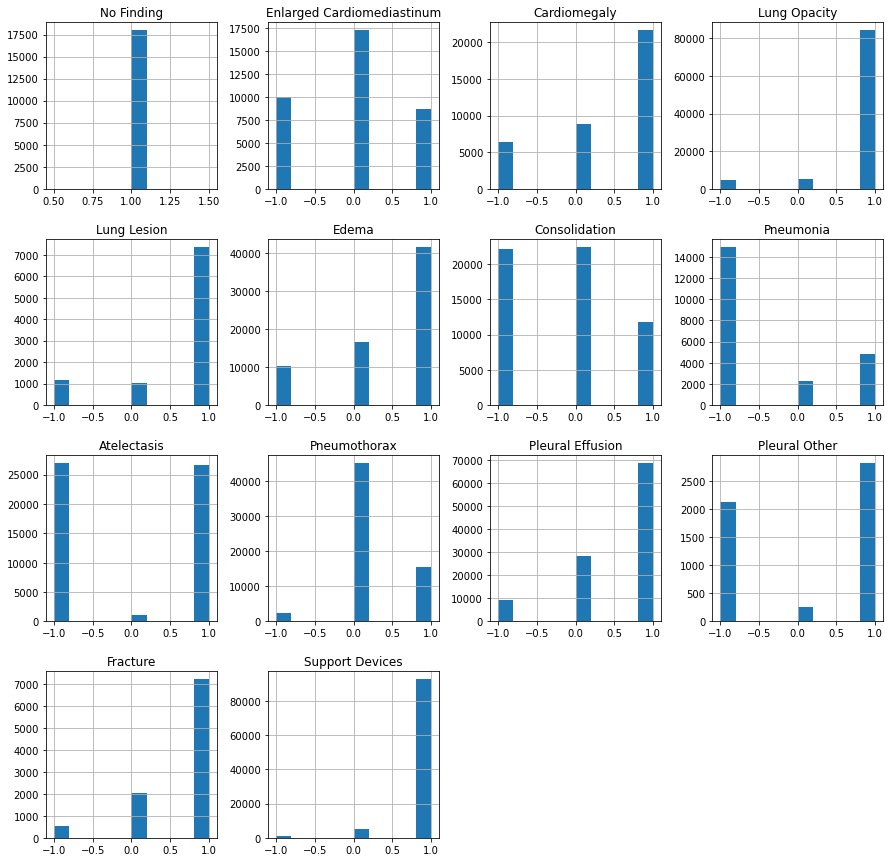

In [162]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
_ = train_valid_df[obs_columns].hist(ax = ax)

There are large number of uncertain labels for certain classes of pathology. Therefore, we cannot ignore or discard the dataset.

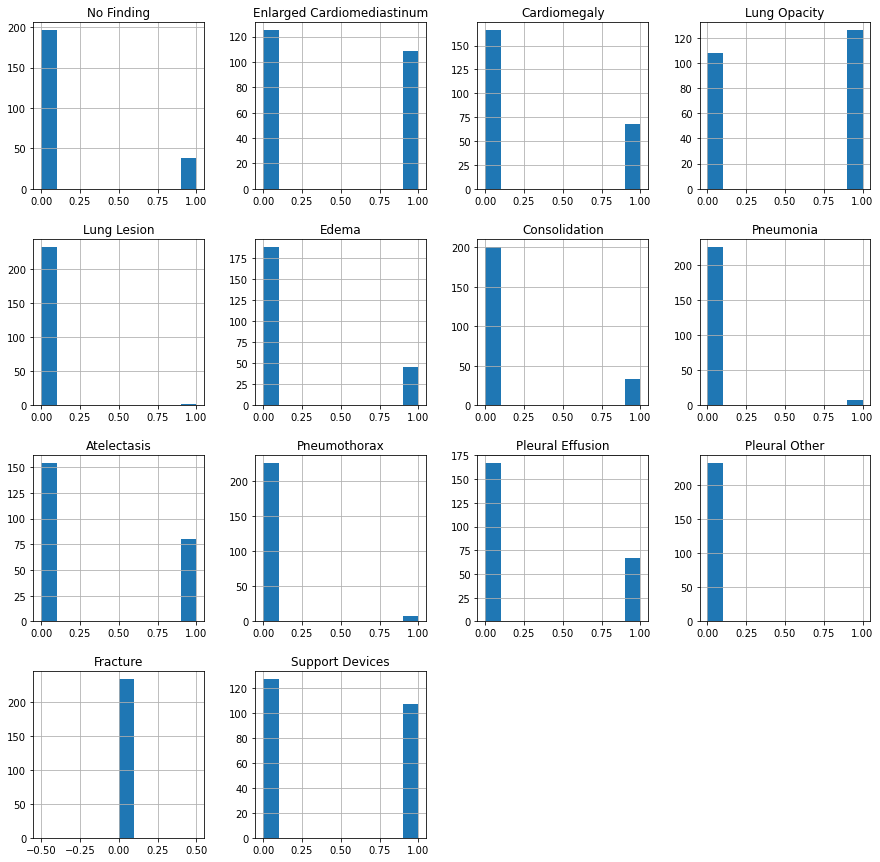

In [163]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
_ = rad_test_df[obs_columns].hist(ax = ax)

We should select the following 5 pathology for evaluation:

* Atelectasis	
* Cardiomegaly	
* Consolidation	
* Edema	
* Pleural Effusion

<AxesSubplot:>

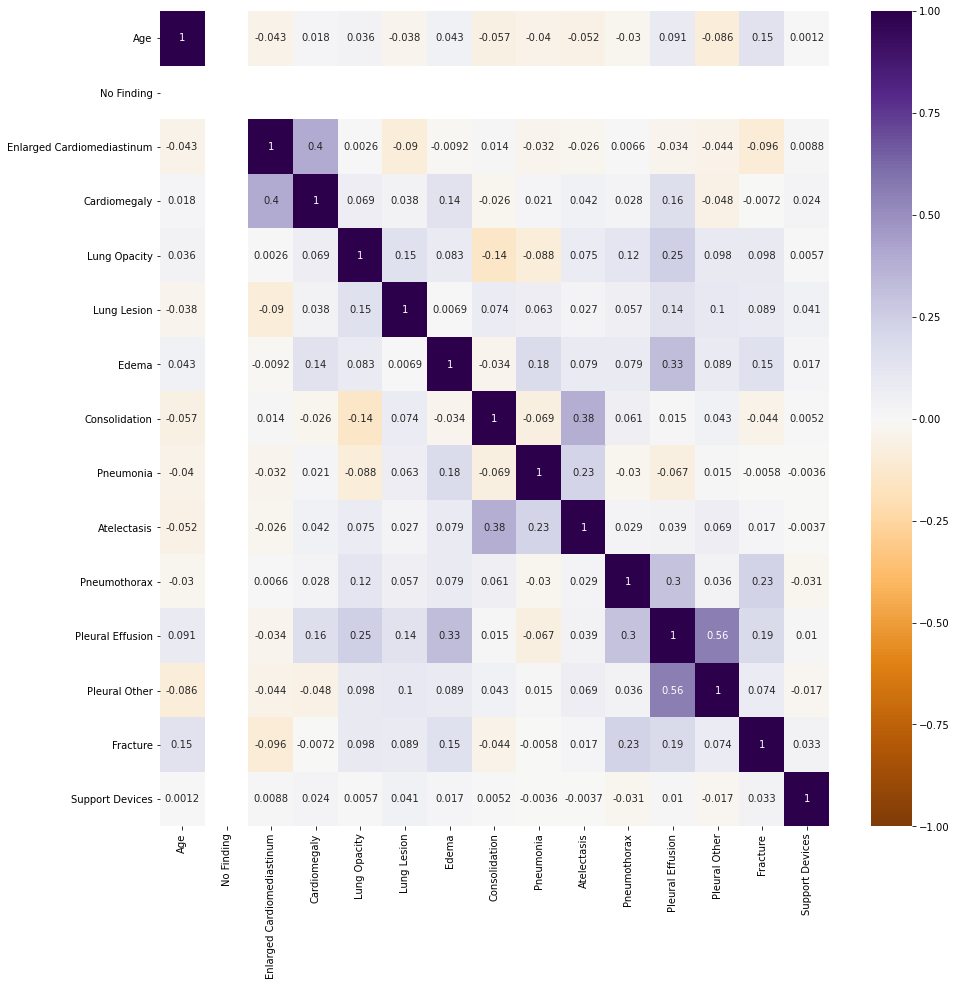

In [164]:
fig = plt.figure(figsize=(15,15))
sns.heatmap(train_valid_df.corr(), vmin=-1, vmax=1, cmap='PuOr', annot=True)

In [165]:
raw_path = r'C:\Users\songh\Google Drive\ISS610\chexpert-aml\data\raw\CheXpert-v1.0-small'
train_valid_df['Path'] = train_valid_df['Path'].apply(lambda x: x.replace('CheXpert-v1.0-small', raw_path))
test_df['Path'] = test_df['Path'].apply(lambda x: x.replace('CheXpert-v1.0-small', raw_path))

In [166]:
train_valid_df[obs_columns].head()

No Finding  Enlarged Cardiomediastinum  Cardiomegaly  Lung Opacity  \
66160          NaN                         NaN           NaN           1.0   
133842         NaN                         NaN           1.0           NaN   
134706         NaN                         NaN           1.0           1.0   
218900         NaN                         0.0           NaN           1.0   
212076         NaN                         NaN           NaN           1.0   

        Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
66160           NaN    NaN            NaN        NaN          NaN   
133842          NaN    0.0            NaN        NaN          1.0   
134706          NaN    1.0            NaN       -1.0         -1.0   
218900          NaN    NaN            NaN        1.0          NaN   
212076          NaN    1.0            NaN        NaN          NaN   

        Pneumothorax  Pleural Effusion  Pleural Other  Fracture  \
66160            1.0               1.0            NaN       NaN   
133842           NaN               1.0            NaN       NaN   
134706           NaN               1.0            NaN       NaN   
218900           NaN               1.0            NaN       NaN   
212076           NaN               1.0            NaN       NaN   

        Support Devices  
66160               1.0  
133842              1.0  
134706              NaN  
218900              NaN  
212076              1.0

In [167]:
#replace missing values with negatives
train_valid_df[obs_columns] = train_valid_df[obs_columns].replace(np.nan, 0)
train_valid_df = train_valid_df[train_valid_df['Sex'] != 'Unknown']
test_df[obs_columns] = test_df[obs_columns].replace(np.nan, 0)

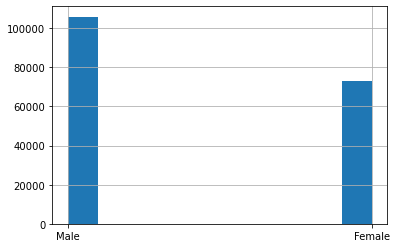

In [168]:
_ = train_valid_df['Sex'].hist()

In [169]:
train_valid_df.groupby(by=['Sex']).count()

Path     Age  Frontal/Lateral  AP/PA  No Finding  \
Sex                                                          
Female   72842   72842            72842  63258       72842   
Male    105888  105888           105888  89446      105888   

        Enlarged Cardiomediastinum  Cardiomegaly  Lung Opacity  Lung Lesion  \
Sex                                                                           
Female                       72842         72842         72842        72842   
Male                        105888        105888        105888       105888   

         Edema  Consolidation  Pneumonia  Atelectasis  Pneumothorax  \
Sex                                                                   
Female   72842          72842      72842        72842         72842   
Male    105888         105888     105888       105888        105888   

        Pleural Effusion  Pleural Other  Fracture  Support Devices  
Sex                                                                 
Female             72842          72842     72842            72842  
Male              105888         105888    105888           105888

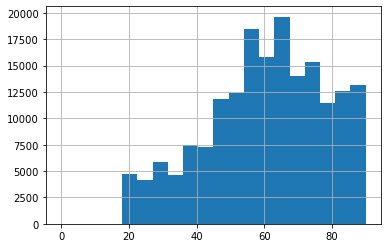

In [170]:
_ = train_valid_df['Age'].hist(bins=20)

<AxesSubplot:>

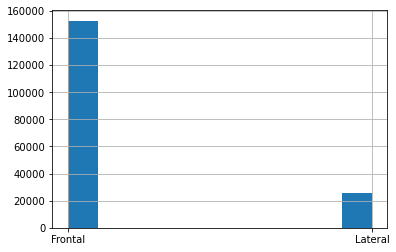

In [171]:
train_valid_df['Frontal/Lateral'].hist()

In [172]:
#Percentage of positive labels
for c in obs_columns:
    perc = (train_valid_df[c] == 1).sum()/len(train_valid_df) * 100
    perc = round(perc, 2)
    print (f"{c}:{perc} %")

No Finding:10.06 %
Enlarged Cardiomediastinum:4.84 %
Cardiomegaly:12.11 %
Lung Opacity:47.19 %
Lung Lesion:4.13 %
Edema:23.37 %
Consolidation:6.6 %
Pneumonia:2.7 %
Atelectasis:14.89 %
Pneumothorax:8.73 %
Pleural Effusion:38.47 %
Pleural Other:1.58 %
Fracture:4.04 %
Support Devices:51.93 %


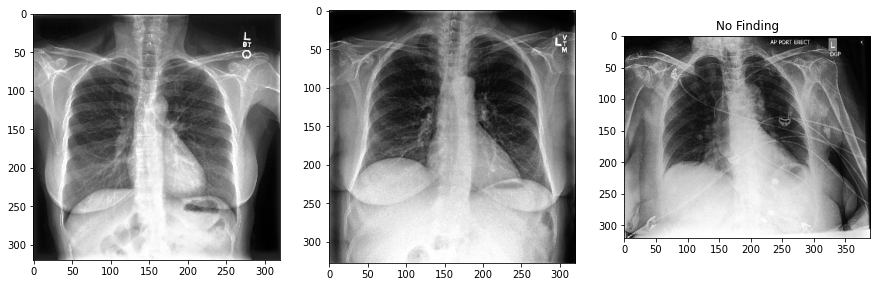

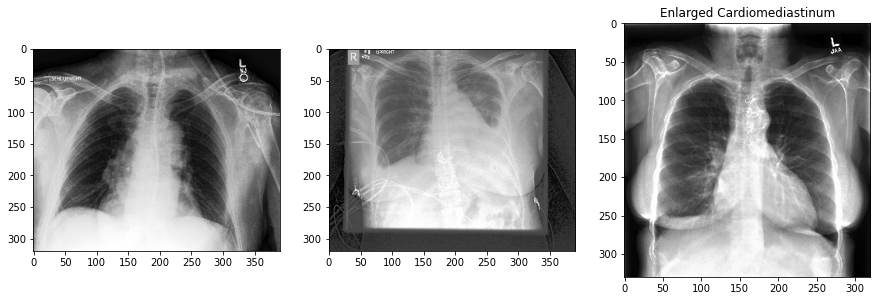

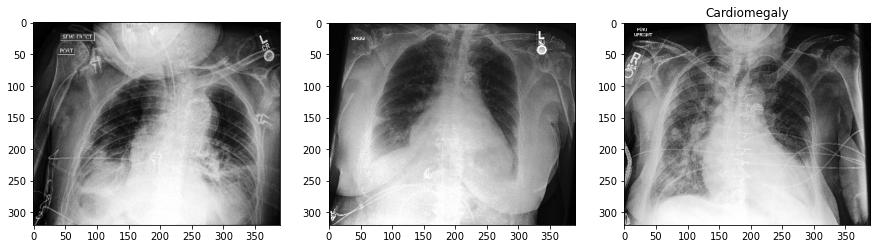

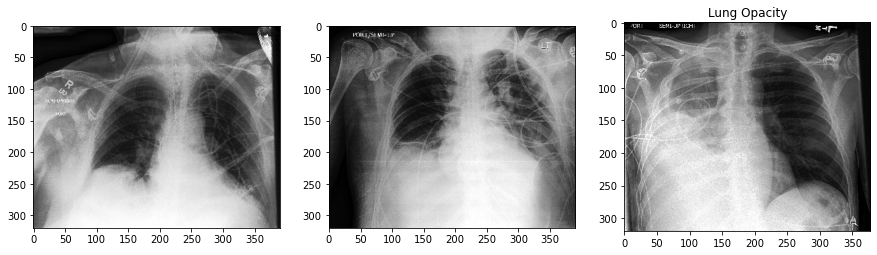

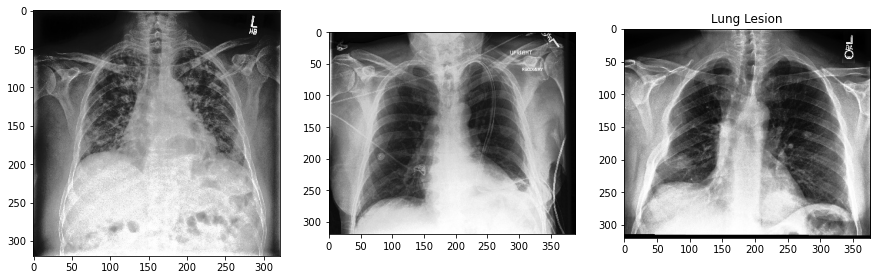

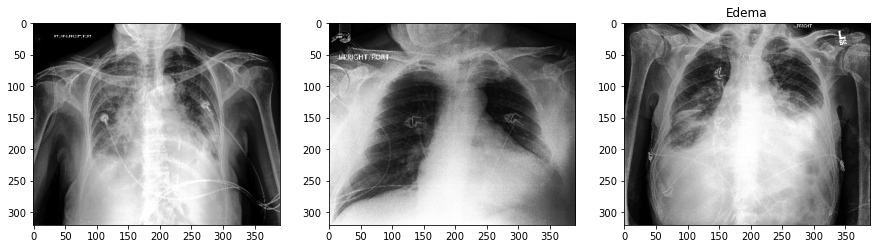

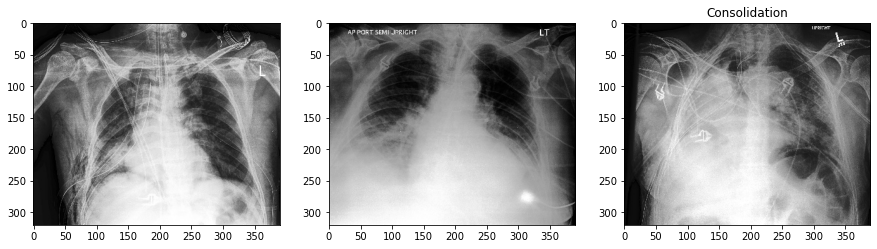

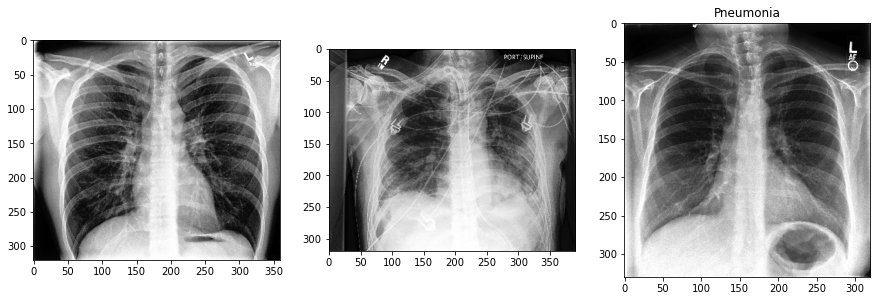

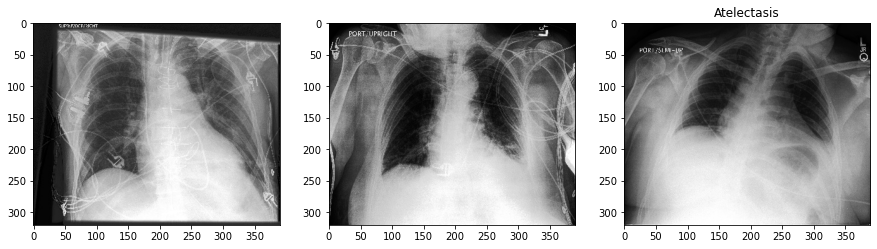

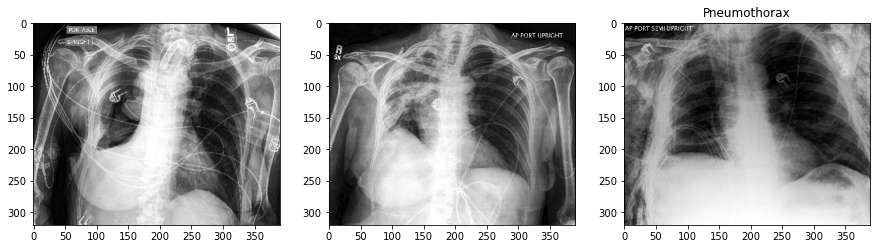

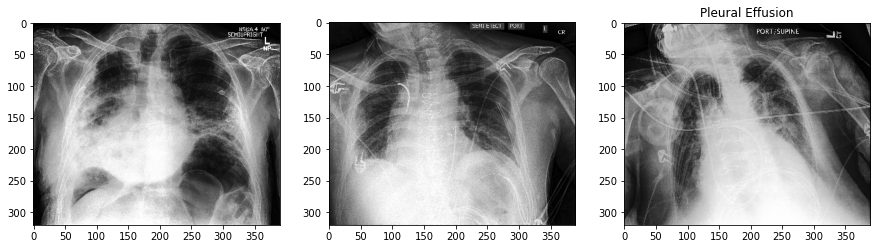

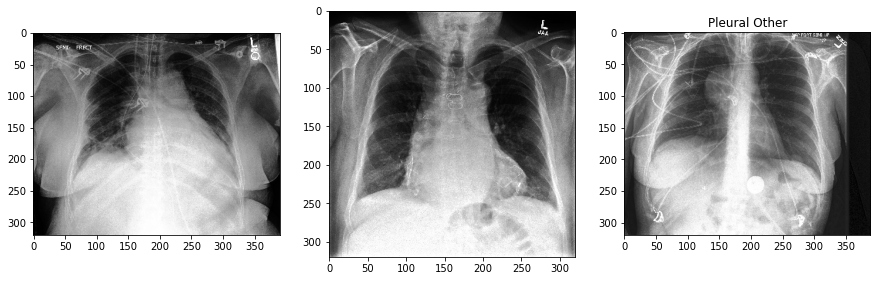

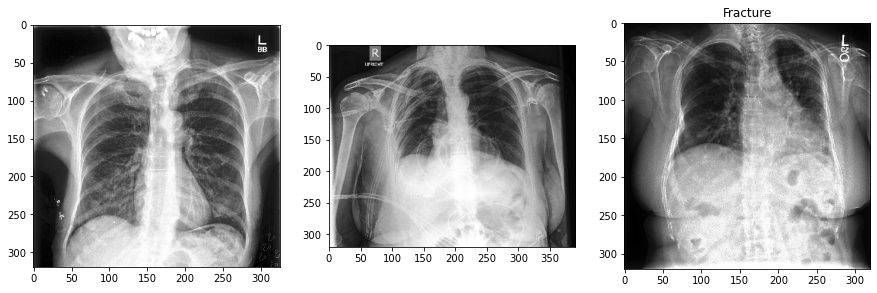

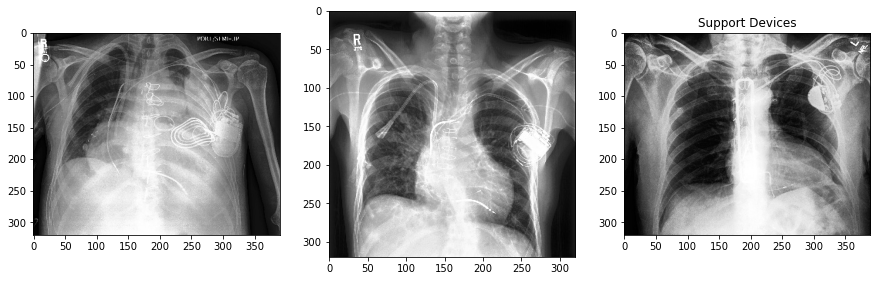

In [173]:
n_col, n_row = 3, 1
for pathology in obs_columns:
    df = train_valid_df[(train_valid_df[pathology] == 1.0) & (train_valid_df['Frontal/Lateral'] == 'Frontal')].sample(n=n_col * n_row)
    df.reset_index(inplace=True, drop=True)
    fig, axs= plt.subplots(n_row, n_col, figsize=(15,15))
    for idx, row in df.iterrows():
        img = cv2.imread(row['Path'],0)
        axs[idx].imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.title(pathology)

## Multilabel Classification

In [174]:
#random assignment to uncertain labels
for pathology in obs_columns:
    sum_positive = (train_valid_df[pathology] == 1.0).sum()
    sum_negative = (train_valid_df[pathology] == 0.0).sum()
    prob_positive = sum_positive/(sum_positive + sum_negative)
    list_size = train_valid_df[train_valid_df[pathology] == -1.0][pathology].size
    random_list = np.random.choice(a=[0, 1], p=[1-prob_positive, prob_positive], size=list_size)
    train_valid_df.loc[train_valid_df[pathology] == -1.0, pathology] = random_list


In [175]:
frontal_df = train_valid_df[train_valid_df['Frontal/Lateral'] == 'Frontal']
cols = ['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'Edema']
frontal_df = frontal_df[cols]
frontal_df.head()

Path     Sex  Age  \
66160   C:\Users\songh\Google Drive\ISS610\chexpert-am...    Male   37   
133842  C:\Users\songh\Google Drive\ISS610\chexpert-am...  Female   32   
134706  C:\Users\songh\Google Drive\ISS610\chexpert-am...  Female   77   
218900  C:\Users\songh\Google Drive\ISS610\chexpert-am...    Male   80   
212076  C:\Users\songh\Google Drive\ISS610\chexpert-am...    Male   55   

       Frontal/Lateral AP/PA  Edema  
66160          Frontal    PA    0.0  
133842         Frontal    AP    0.0  
134706         Frontal    AP    1.0  
218900         Frontal    AP    0.0  
212076         Frontal    AP    1.0

In [176]:
frontal_test_df = test_df[test_df['Frontal/Lateral'] == 'Frontal']
cols = ['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'Edema']
frontal_test_df = frontal_test_df[cols]
frontal_test_df.head()

Path     Sex  Age  \
0  C:\Users\songh\Google Drive\ISS610\chexpert-am...    Male   73   
1  C:\Users\songh\Google Drive\ISS610\chexpert-am...    Male   70   
3  C:\Users\songh\Google Drive\ISS610\chexpert-am...    Male   85   
4  C:\Users\songh\Google Drive\ISS610\chexpert-am...  Female   42   
5  C:\Users\songh\Google Drive\ISS610\chexpert-am...  Female   55   

  Frontal/Lateral AP/PA  Edema  
0         Frontal    AP    0.0  
1         Frontal    PA    0.0  
3         Frontal    AP    1.0  
4         Frontal    AP    0.0  
5         Frontal    AP    0.0

In [177]:
from sklearn.utils import resample
N = 1000
frontal_df_majority = frontal_df[frontal_df['Edema'] == 1.0].sample(n=N)
frontal_df_minority = frontal_df[frontal_df['Edema'] == 0.0]
edema_df = resample(frontal_df_minority, n_samples=len(frontal_df_majority), replace=True)
edema_df = pd.concat([frontal_df_majority, edema_df])

Path     Sex  Age  \
0     C:\Users\songh\Google Drive\ISS610\chexpert-am...    Male   44   
1     C:\Users\songh\Google Drive\ISS610\chexpert-am...    Male   61   
2     C:\Users\songh\Google Drive\ISS610\chexpert-am...  Female   44   
3     C:\Users\songh\Google Drive\ISS610\chexpert-am...  Female   64   
4     C:\Users\songh\Google Drive\ISS610\chexpert-am...  Female   68   
...                                                 ...     ...  ...   
1995  C:\Users\songh\Google Drive\ISS610\chexpert-am...  Female   76   
1996  C:\Users\songh\Google Drive\ISS610\chexpert-am...  Female   82   
1997  C:\Users\songh\Google Drive\ISS610\chexpert-am...    Male   55   
1998  C:\Users\songh\Google Drive\ISS610\chexpert-am...  Female   32   
1999  C:\Users\songh\Google Drive\ISS610\chexpert-am...  Female   58   

     Frontal/Lateral AP/PA  Edema  
0            Frontal    PA    1.0  
1            Frontal    AP    1.0  
2            Frontal    AP    1.0  
3            Frontal    AP    1.0  
4            Frontal    AP    1.0  
...              ...   ...    ...  
1995         Frontal    PA    0.0  
1996         Frontal    PA    0.0  
1997         Frontal    AP    0.0  
1998         Frontal    PA    0.0  
1999         Frontal    AP    0.0  

[2000 rows x 6 columns]

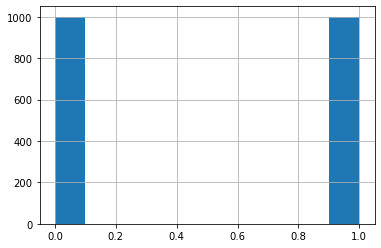

In [178]:
edema_df['Edema'].hist()
edema_df.reset_index(inplace=True, drop=True)
edema_df

In [179]:
from skimage import exposure

def read_image_and_label(df, label_name):
    images = []
    labels = []
    for i in range(len(df)):
        img = imread(df.loc[i, "Path"])
        #img = exposure.equalize_hist(img)
        label = df.loc[i, label_name]
        images.append(img)
        labels.append(label)
    return images, labels

In [180]:
images, labels = read_image_and_label(edema_df, 'Edema')

In [181]:
#  Flattening and Reshaping the data.
def resize_and_flatten(images, size=(320, 320)):
    result = []
    for img in images:
        new_img = resize(img, size)
        flatted = np.ndarray.flatten(new_img)
        result.append(flatted)
    return result

flat_images = resize_and_flatten(images)


In [182]:
def create_dataframe(images, labels):
    df1 = pd.DataFrame(images)
    df2 = pd.DataFrame(labels, columns=["label"])
    return pd.concat([df1, df2], axis=1)

In [183]:
image_df = create_dataframe(flat_images, labels)

In [184]:
x = image_df.values[:, :-1]
y = image_df.values[:, -1]

In [185]:
#frontal_test_df = frontal_test_df[frontal_test_df['Edema'] != 0.0]
#frontal_test_df.reset_index(inplace=True,drop=True)
frontal_test_df_subset = frontal_test_df
frontal_test_df_subset.reset_index(inplace=True,drop=True)

In [186]:
images_test, labels_test = read_image_and_label(frontal_test_df_subset, 'Edema')
flat_images_test = resize_and_flatten(images_test)
image_test_df = create_dataframe(flat_images_test, labels_test)

In [187]:
x_test = image_test_df.values[:, :-1]
y_test = image_test_df.values[:, -1]

In [188]:
from sklearn.decomposition import PCA, IncrementalPCA                   
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(X=x)

In [189]:
pca_n = 40
pca = PCA(n_components=pca_n, whiten=True)
x_pca = pca.fit_transform(x_scaled)

In [190]:
eigenlung = pca.components_.reshape((pca_n, 320, 320))

In [191]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
eigenlung_titles = ["Eigenlung %d" % i for i in range(eigenlung.shape[0])]

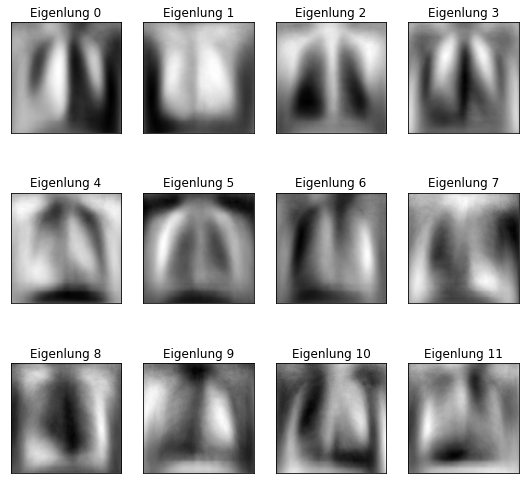

In [192]:
plot_gallery(eigenlung, eigenlung_titles, 320, 320)

In [193]:
df1 = pd.DataFrame(x_pca)
df2 = pd.DataFrame(y, columns=["label"])
join_df = pd.concat([df1, df2], axis=1)

In [194]:
join_df.groupby('label').mean()

0         1         2         3         4       5         6   \
label                                                                      
0.0   -0.02948 -0.127277  0.171355  0.008894  0.127446  0.0132 -0.052583   
1.0    0.02948  0.127277 -0.171355 -0.008894 -0.127446 -0.0132  0.052583   

             7         8         9   ...        30        31        32  \
label                                ...                                 
0.0   -0.051801  0.175194  0.019895  ...  0.089292  0.012811 -0.013095   
1.0    0.051801 -0.175194 -0.019895  ... -0.089292 -0.012811  0.013095   

             33        34        35        36        37        38        39  
label                                                                        
0.0   -0.061987  0.018597  0.005567 -0.040823 -0.014011 -0.005828 -0.018693  
1.0    0.061987 -0.018597 -0.005567  0.040823  0.014011  0.005828  0.018693  

[2 rows x 40 columns]

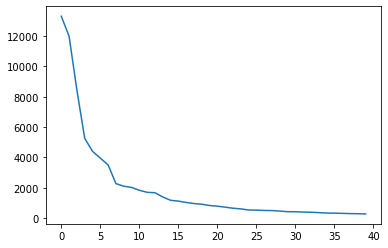

In [195]:
plt.plot(pca.explained_variance_)

In [196]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
x_pca_scale = MinMaxScaler().fit_transform(x_pca)
rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=15, min_samples_split=6, min_samples_leaf=3, bootstrap=True, oob_score=False, n_jobs=-1, random_state=2019)
rf.fit(X=x_pca_scale, y=y)

RandomForestClassifier(max_depth=15, min_samples_leaf=3, min_samples_split=6,
                       n_jobs=-1, random_state=2019)

In [197]:
nb_pca = GaussianNB()
nb_pca.fit(X=x_pca_scale, y=y)

GaussianNB()

In [198]:
from sklearn.metrics import roc_auc_score, roc_curve
score = rf.predict_proba(X=x_pca_scale)[:,1]
roc_auc_score(y_true=y, y_score=score)

0.999997

In [199]:
x_test_scaled = scaler.transform(X=x_test)
x_pca_test = pca.fit_transform(x_test_scaled)
x_pca_test_scale = MinMaxScaler().fit_transform(x_pca_test)

In [200]:
score = rf.predict_proba(X=x_pca_test_scale)[:,1]
print(f"RF test score: {roc_auc_score(y_true=y_test, y_score=score)}")

RF test score: 0.6956845238095238


In [201]:
score = nb_pca.predict_proba(X=x_pca_scale)[:,1]
roc_auc_score(y_true=y, y_score=score)

0.692811

In [202]:
score = nb_pca.predict_proba(X=x_pca_test_scale)[:,1]
print(f"NB + PCA test score: {roc_auc_score(y_true=y_test, y_score=score)}")

NB + PCA test score: 0.6845238095238095


In [203]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve, f1_score

nb_raw = GaussianNB()
x_scaled_pos = MinMaxScaler().fit_transform(x_scaled)
nb_raw.fit(X=x_scaled_pos, y=y)
x_test_scaled_pos = MinMaxScaler().fit_transform(x_test_scaled)
score = nb_raw.predict_proba(X=x_test_scaled_pos)[:,1]
print(f"NB + scaling test score: {roc_auc_score(y_true=y_test, y_score=score)}")

NB + scaling test score: 0.6790178571428571


In [204]:
nb_raw_not_scaled = GaussianNB()
nb_raw_not_scaled.fit(X=x, y=y)
score = nb_raw_not_scaled.predict_proba(X=x_test)[:,1]
print(f"NB without scaling test score: {roc_auc_score(y_true=y_test, y_score=score)}")

NB without scaling test score: 0.6607886904761905


In [205]:
score = nb_raw.predict_proba(X=x_scaled_pos)[:,1]
roc_auc_score(y_true=y, y_score=score)

0.628811

In [206]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.01)
lr.fit(X=x_pca_scale, y=y)
score = lr.predict_proba(X=x_pca_test_scale)[:,1]
print(f"Logistic Regression + PCA test score: {roc_auc_score(y_true=y_test, y_score=score)}")

Logistic Regression + PCA test score: 0.7248511904761904


In [207]:
lr_raw = LogisticRegression(C=0.01)
lr_raw.fit(X=x_scaled_pos, y=y)
score = lr_raw.predict_proba(X=x_test_scaled_pos)[:,1]
print(f"LR + scaling test score: {roc_auc_score(y_true=y_test, y_score=score)}")

LR + scaling test score: 0.7224702380952381


In [208]:
from skimage import data
from skimage import color
from skimage.filters import meijering, sato, frangi, hessian
import matplotlib.pyplot as plt

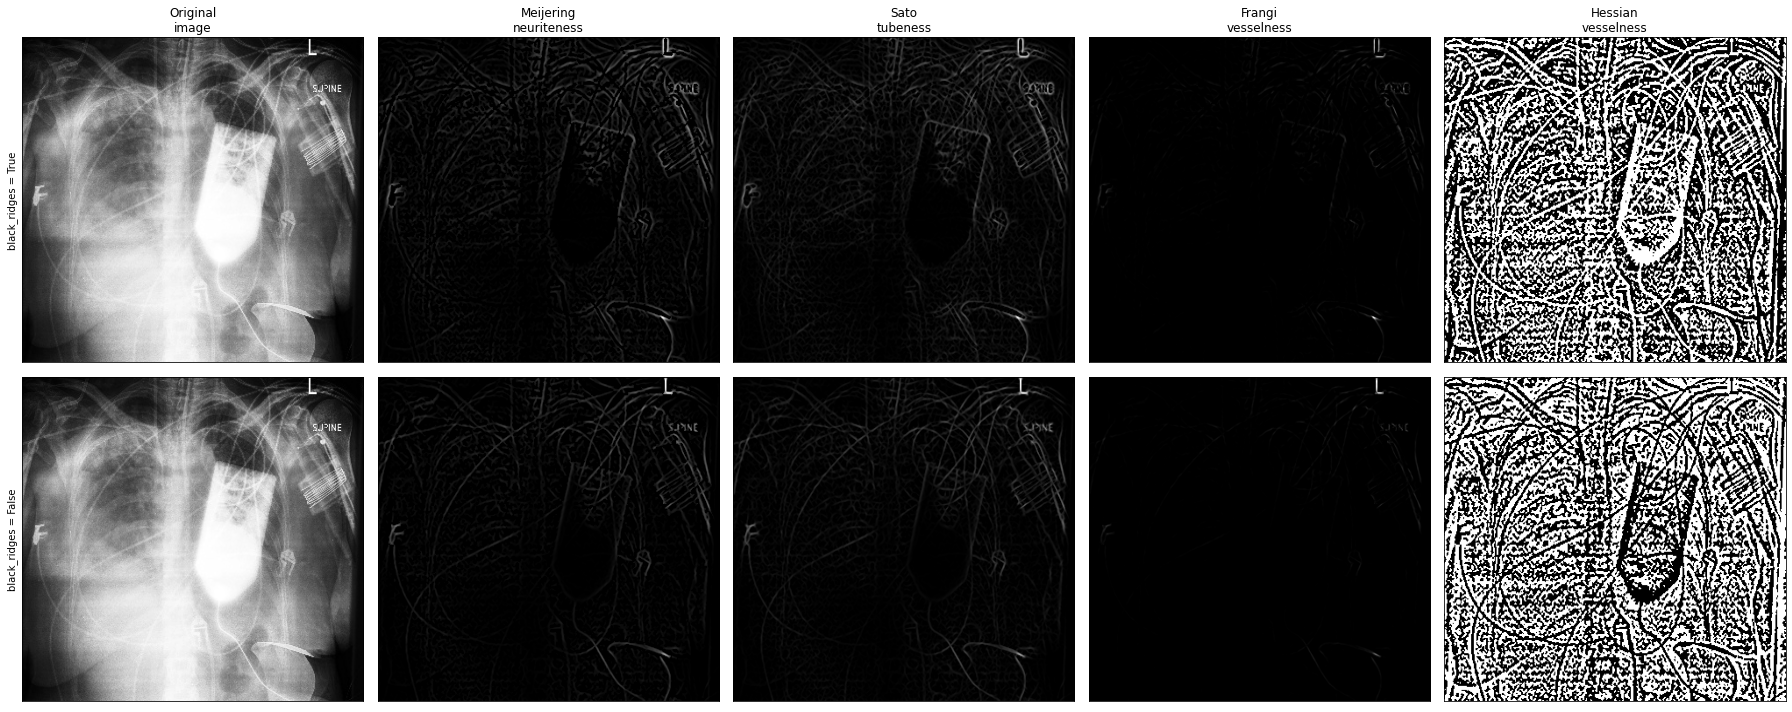

In [157]:
from skimage import data
from skimage import color
from skimage.filters import meijering, sato, frangi, hessian
import matplotlib.pyplot as plt


def identity(image, **kwargs):
    """Return the original image, ignoring any kwargs."""
    return image


image = img
cmap = plt.cm.gray

kwargs = {'sigmas': [1], 'mode': 'reflect'}

fig, axes = plt.subplots(2, 5, figsize=(25,10))
for i, black_ridges in enumerate([1, 0]):
    for j, func in enumerate([identity, meijering, sato, frangi, hessian]):
        kwargs['black_ridges'] = black_ridges
        result = func(image, **kwargs)
        axes[i, j].imshow(result, cmap=cmap, aspect='auto')
        if i == 0:
            axes[i, j].set_title(['Original\nimage', 'Meijering\nneuriteness',
                                  'Sato\ntubeness', 'Frangi\nvesselness',
                                  'Hessian\nvesselness'][j])
        if j == 0:
            axes[i, j].set_ylabel('black_ridges = ' + str(bool(black_ridges)))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.tight_layout()
plt.show()

In [139]:
val = filters.threshold_otsu(img)
mask = img < val

In [150]:
from skimage import exposure
img_histeq = exposure.equalize_hist(img)
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

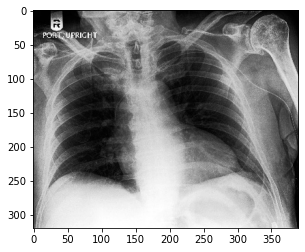

In [153]:
plt.imshow(img_histeq, cmap = plt.cm.gray)

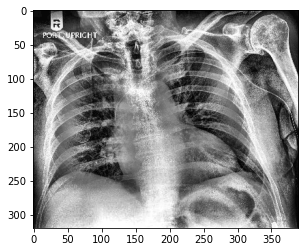

In [156]:
plt.imshow(img_adapteq, cmap = plt.cm.gray)

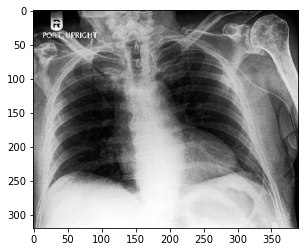

In [155]:
plt.imshow(img, cmap = plt.cm.gray)